In [1]:
import pandas as pd
import numpy as np
import tensorflow 
from warnings import filterwarnings
filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
sns.set()
from tensorflow.keras.layers import Dense,LSTM,Input,RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras import models,layers,activations,losses,optimizers,metrics
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import recall_score, auc, roc_curve

In [2]:
df = pd.read_csv('C:/Users/HP/dataset/creditcard.csv')

In [3]:
df_selected = df.drop(['V15','V17','V24','V27','Time'], axis = 1)
df_selected.shape

(284807, 26)

In [4]:
predictors = df_selected.drop(["Class"], axis = 1)
target = df_selected["Class"]

In [5]:
predictors.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V18,V19,V20,V21,V22,V23,V25,V26,V28,Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.128539,-0.189115,-0.021053,149.62
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,0.167170,0.125895,0.014724,2.69
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.327642,-0.139097,-0.059752,378.66
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,0.647376,-0.221929,0.061458,123.50
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,-0.206010,0.502292,0.215153,69.99


In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().set_output(transform="pandas")
X_train_sc = scaler.fit_transform(predictors)

In [7]:
X_train_sc.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V18,V19,V20,V21,V22,V23,V25,V26,V28,Amount
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.655066,0.594863,0.582942,0.561184,0.522992,0.663793,0.585122,0.394557,0.312697,0.005824
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.640681,0.551930,0.579530,0.557840,0.480237,0.666938,0.587290,0.446013,0.313423,0.000105
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.644945,0.386683,0.585855,0.565477,0.546030,0.678939,0.559515,0.402727,0.311911,0.014739
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.788492,0.467058,0.578050,0.559734,0.510277,0.662607,0.614245,0.389197,0.314371,0.004807
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.650665,0.626060,0.584615,0.561327,0.547271,0.663392,0.566343,0.507497,0.317490,0.002724


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_sc, target, 
    stratify = target, 
    random_state = 13, 
    test_size = 0.25)

In [9]:
X_val = X_test[:3000]
y_val = y_test[:3000]
X_test = X_test[3000:]
y_test = y_test[3000:]
X_train_0 = X_train[y_train != 1]
y_train_0 = y_train[y_train != 1]
X_test_0 = X_test[y_test != 1]
X_val_0 = X_val[y_val != 1]
y_train_0 = y_train[y_train != 1]

In [10]:
def arr_reshape(x, arr_type = "float32"):
    return np.asarray(x).astype(arr_type).reshape((-1, 1, x.shape[1]))
def flatten(arr):
    return arr.reshape(-1, arr.shape[-1])
def mse_3d(x, y):
    return np.mean(np.power(flatten(x) - flatten(y), 2), axis = 1)

In [11]:
reshaped_train_0 = arr_reshape(X_train_0)
reshaped_val_0 = arr_reshape(X_val_0)
reshaped_test_0 = arr_reshape(X_test_0)
reshaped_val = arr_reshape(X_val)
reshaped_test = arr_reshape(X_test)
reshaped_train = arr_reshape(X_train)

In [12]:
inputs_dim = reshaped_train_0.shape[2]
print(inputs_dim)

25


In [13]:
def build_model(n_dims):
        inputs = Input(shape = (1, n_dims))
        e = LSTM(16, activation = "relu", return_sequences = True)(inputs)
        bottleneck = LSTM(8, activation = "relu", 
                               return_sequences = False, 
                               name = "Bottleneck")(e)
        e = RepeatVector(1)(bottleneck)
        decoder = LSTM(8, activation = "relu", 
                       return_sequences = True)(e)
        decoder = LSTM(16, activation = "relu", return_sequences = True)(decoder)
        outputs = TimeDistributed(Dense(n_dims))(decoder)
        model = Model(inputs = inputs, outputs = outputs)
        return model

In [14]:
model = build_model(inputs_dim)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 25)]           0         
                                                                 
 lstm (LSTM)                 (None, 1, 16)             2688      
                                                                 
 Bottleneck (LSTM)           (None, 8)                 800       
                                                                 
 repeat_vector (RepeatVector  (None, 1, 8)             0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 1, 8)              544       
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             1600      
                                                             

In [15]:
def compile_model(model, lr = 0.0003, loss = "mse", opt = "adam"):
    if opt == "adam":
        opt = optimizers.Adam(learning_rate = lr)
    else:
        opt = optimizers.SGD(learning_rate = lr)
    model.compile(loss = loss, optimizer = opt)
    
    
def callbacks(**kwargs):
    mc = ModelCheckpoint(filepath = kwargs.get("filename"), save_best_only = True, verbose = 0)
    es = EarlyStopping(monitor = kwargs.get("monitor"), patience = kwargs.get("patience"))
    return mc,es
        
def train(model, x, y, x_val = None, y_val = None,  n_epochs = 15, batch_size = 32, verbose = 1, callbacks = None):
    if x_val is not None:
        model.fit(x, y, validation_split = 0.2,epochs = n_epochs, verbose = verbose,batch_size = batch_size)
    else:
        model.fit(x, y, validation_data = (x_val, y_val),epochs = n_epochs, verbose = verbose,batch_size = batch_size, callbacks = [mc, es])
    

In [16]:
mc,es = callbacks(filename = "./lstm_autoenc.h5", patience = 3, monitor = "val_loss")
compile_model(model)
train(model,reshaped_train_0, reshaped_train_0, reshaped_val_0, reshaped_val_0, n_epochs = 10)

Epoch 1/10
5331/5331 [==============================] - 23s 4ms/step - loss: 0.0148 - val_loss: 0.0014
Epoch 2/10
5331/5331 [==============================] - 19s 4ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 3/10
5331/5331 [==============================] - 19s 4ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 4/10
5331/5331 [==============================] - 19s 4ms/step - loss: 9.0176e-04 - val_loss: 7.9715e-04
Epoch 5/10
5331/5331 [==============================] - 19s 4ms/step - loss: 7.7781e-04 - val_loss: 7.3771e-04
Epoch 6/10
5331/5331 [==============================] - 20s 4ms/step - loss: 7.0556e-04 - val_loss: 6.7139e-04
Epoch 7/10
5331/5331 [==============================] - 19s 4ms/step - loss: 6.6353e-04 - val_loss: 6.5322e-04
Epoch 8/10
5331/5331 [==============================] - 19s 4ms/step - loss: 6.4996e-04 - val_loss: 6.3903e-04
Epoch 9/10
5331/5331 [==============================] - 19s 4ms/step - loss: 6.3749e-04 - val_loss: 6.2381e-04
Epoch 10/10
5331/5331 [==

In [17]:
def predict(model, xtest):
    return model.predict(xtest)
    
def predict_class(x_test, predicted, threshold):
    mse = mse_3d(x_test, predicted)
    return 1 * (mse > threshold)

94/94 [==============================] - 1s 1ms/step


<Axes: xlabel='threshold', ylabel='value'>

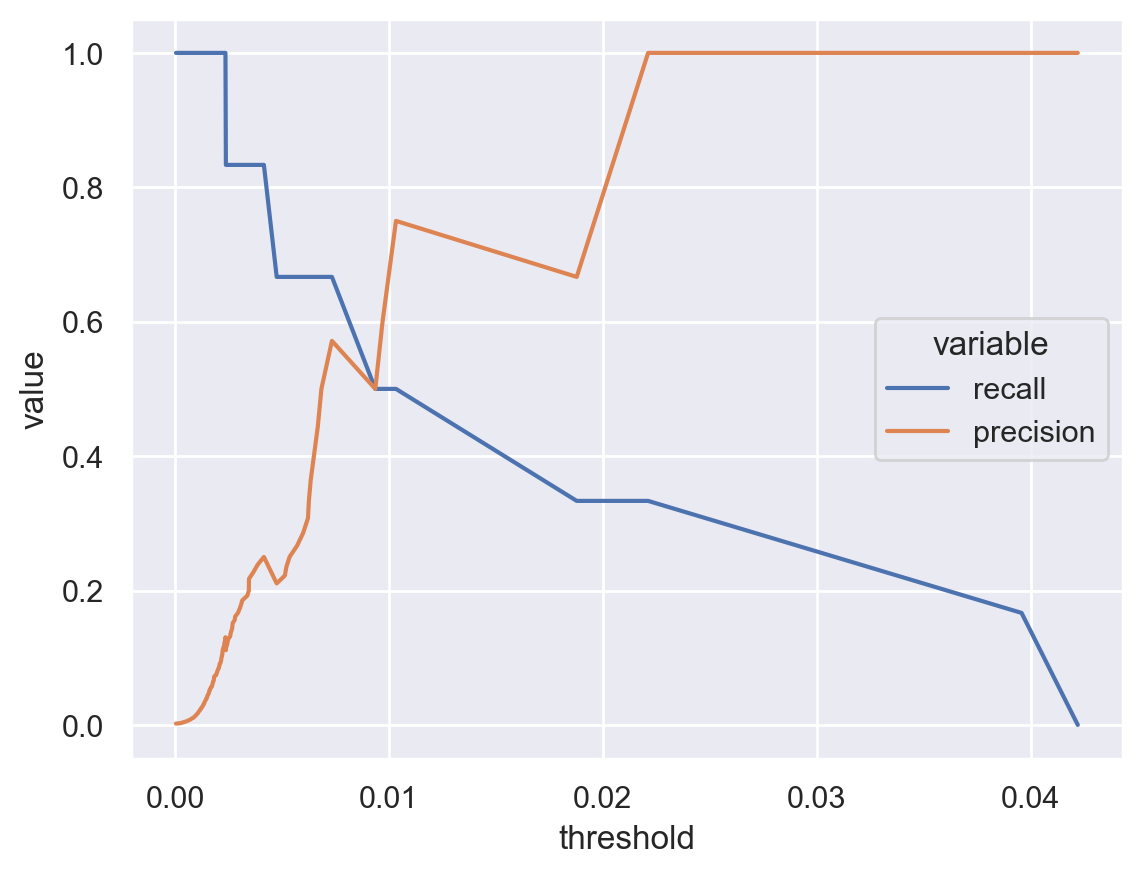

In [18]:
val_preds = predict(model,reshaped_val)
val_mse = mse_3d(reshaped_val, val_preds)
val_error = pd.DataFrame({
    "mse": val_mse,
    "actual": y_val
})
precision, recall, threshold = precision_recall_curve(
    val_error["actual"], val_error["mse"])
val_prt = pd.DataFrame({
    "threshold": threshold,
    "recall": recall[1:],
    "precision": precision[1:]
})
val_prt_melted = pd.melt(val_prt, id_vars = ["threshold"],
                         value_vars = ["recall", "precision"])
sns.lineplot(x = "threshold", y = "value",
             hue = "variable", data = val_prt_melted)

In [19]:
test_preds = predict(model,reshaped_test)
test_mse = mse_3d(reshaped_test, test_preds)
test_error = pd.DataFrame({"mse": test_mse,
                        "actual": y_test})

2132/2132 [==============================] - 3s 1ms/step


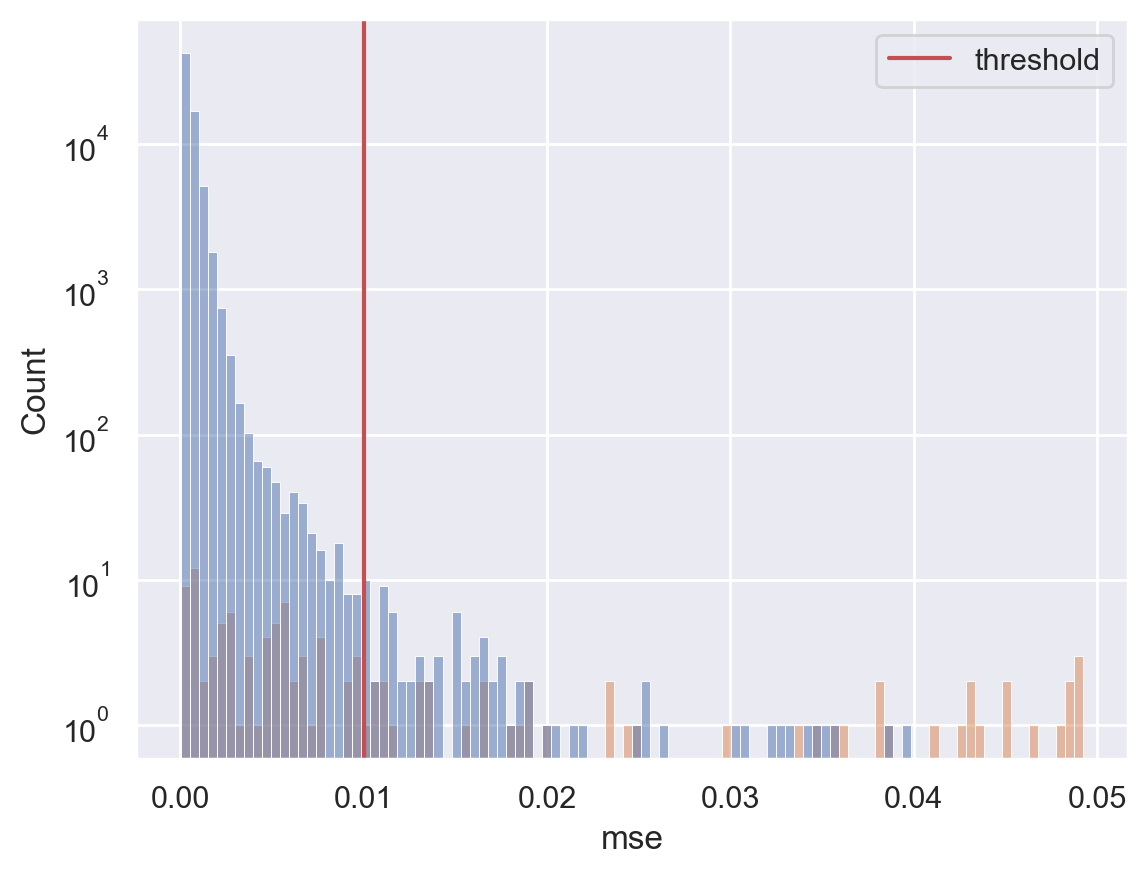

In [20]:
g = sns.histplot(x = "mse", hue = "actual", 
                 data = test_error, bins = 100)
plt.axvline(0.01, color = "r", label = "threshold")
plt.legend(loc = "upper right")
g.set_yscale("log")
plt.show()

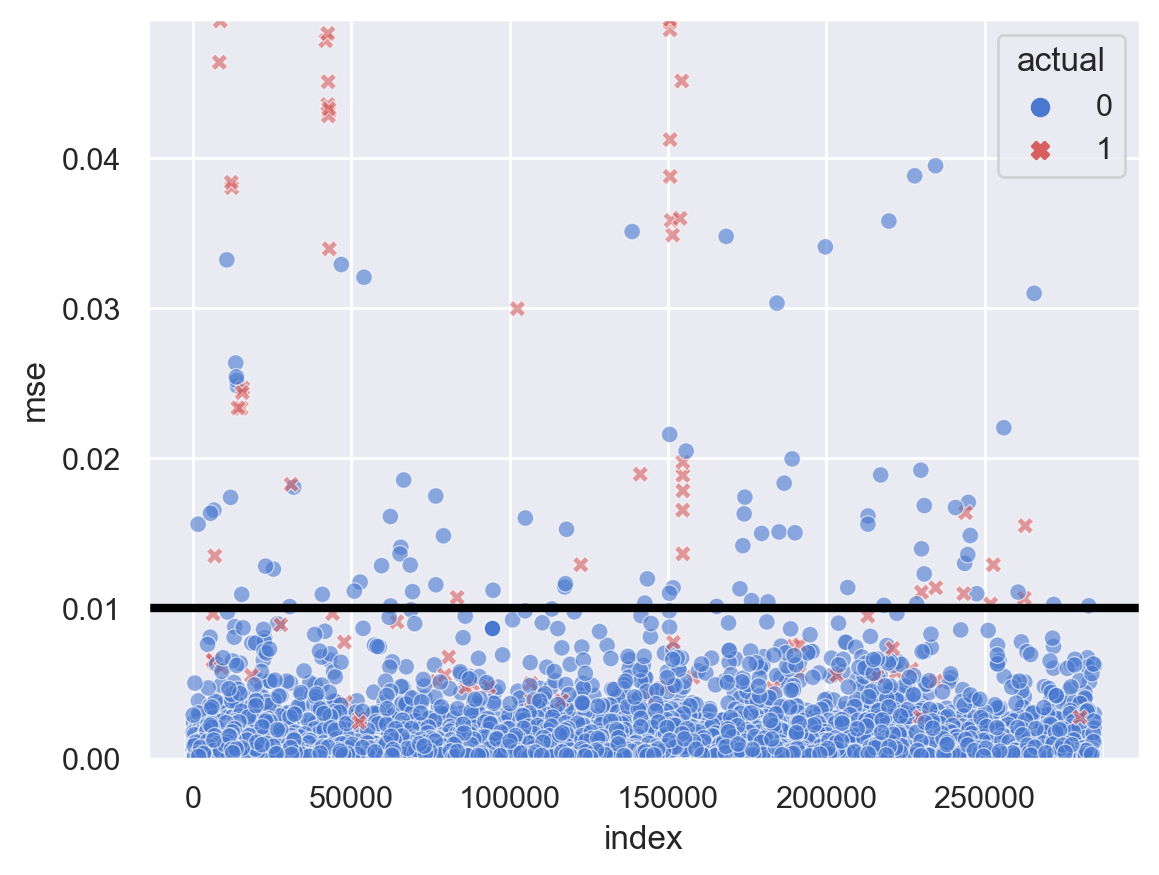

In [21]:
g = sns.scatterplot(
        x = "index", y = "mse", 
        hue = "actual", style = "actual", 
        data = test_error.reset_index(),
        palette = {0: "#4878CF", 1: "#D65F5F"},
        alpha = 0.6)
g.set(ylim = (0, max(test_error.mse)))
g.axhline(0.01, color = "black", linewidth = 3)